<a href="https://colab.research.google.com/github/AraiKensuke/GCoh/blob/master/simulations/simulated_multichannel_EEG_Gcoh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#########  clone and install necessary packages from github repositories

import sys
import importlib

if importlib.util.find_spec("GCoh") is None:
  !git clone https://github.com/AraiKensuke/GCoh.git

if importlib.util.find_spec("mne") is None:
  !pip install mne

sys.path.insert(1, "/content/GCoh")    #  add these to searchpath for python modules

Cloning into 'GCoh'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 105 (delta 60), reused 57 (delta 25), pack-reused 0
Receiving objects: 100% (105/105), 51.25 KiB | 5.69 MiB/s, done.
Resolving deltas: 100% (60/60), done.
     |████████████████████████████████| 6.8MB 2.3MB/s 


In [39]:
#####  Generate simulated EEG data.

import numpy as _N
import os

import GCoh.datconfig as datconf
import GCoh.simulations.sim_utils as _su

#  grpA and grpB   can coexist
#  grpA and grpC   can coexist
#  grpB and grpD   can coexist

grpA = _N.array([1, 2, 5])
grpB = _N.array([3, 4, 8])
grpC = _N.array([7, 8, 9])
grpD = _N.array([1, 6, 7])
grpA_phase_diff = _N.array([0, -2, 5])
grpB_phase_diff = _N.array([0, 10, -3])
grpC_phase_diff = _N.array([0, 1, 1])
grpD_phase_diff = _N.array([0, 0, 0])

dt   = 0.005
nChs = 10
N    = 20000   #(100 s)
f    = 20      #  oscillation frequency 
amp  = 0.995

#  up to 4 groups of
rhythms = _N.zeros((nChs, N))
pknzs   = _N.zeros((nChs, N))
tau     = 0.15    #  timescale of AR1

######  we generate simulated EEG by generating nChs of independent oscillatory
######  signals.  
for nc in range(nChs):
    rhythms[nc] = _su.AR2(f, 0.98, N, dt)
    pknzs[nc] = _su.AR1(tau, N, dt)
EEG     = _N.array(rhythms)

######  
_su.mix(dt, EEG, rhythms, pknzs, grpB, grpB_phase_diff, 18, 30)
_su.mix(dt, EEG, rhythms, pknzs, grpA, grpA_phase_diff, 33, 44)
_su.mix(dt, EEG, rhythms, pknzs, grpB, grpB_phase_diff, 44, 60)
_su.mix(dt, EEG, rhythms, pknzs, grpC, grpC_phase_diff, 65, 90)






In [40]:
import numpy as _N
import scipy.signal as _ssig
import mne.time_frequency as mtf
import mne
import pickle
import sys

import GCoh.chronux_py.chronux_funcs as _chrf
import preprocess_ver

import GCoh.datconfig as datconf
import GCoh.windowed_gcoh as _w_gcoh

dataset =    datconf._SIM
Fs      = 200

artrmv_ver = 1
gcoh_ver    = 5

wnd, slideby      = preprocess_ver.get_win_slideby(gcoh_ver)

rm_chs = []
ch_w_CM = _N.arange(10)

X_cm    = EEG.T

ch_names = ["eeg1", "eeg2", "eeg3", "eeg4", "eeg5", "eeg6", "eeg7", "eeg8", "eeg9", "eeg10"]
ch_types = ["eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg", "eeg"]
ch_picks = _N.setdiff1d(ch_w_CM, _N.array(rm_chs))
arr_ch_picks = _N.array(ch_picks)

info = mne.create_info(ch_names=(_N.array(ch_names)[ch_picks]).tolist(), ch_types=(_N.array(ch_types)[ch_picks]).tolist(), sfreq=Fs)

datconf.set_montage(dataset, info)

dpss_bw=7
f, findx, Ctot, Cvec = _w_gcoh.windowed_gcoh(Fs, wnd, slideby, X_cm, ch_w_CM, ch_picks, info, dpss_bw=dpss_bw)

#pkldat = {"VEC" : Cvec, "Cs" : Ctot, "fs" : f[findx], "chs_picks" : arr_ch_picks, "dpss_bw" : dpss_bw}



    Using multitaper spectrum estimation with 25 DPSS windows
Not setting metadata
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
0  768
128  896
256  1024


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

384  1152
512  1280
640  1408


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

768  1536
896  1664
1024  1792


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

1152  1920
1280  2048
1408  2176


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

1536  2304
1664  2432
1792  2560


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

1920  2688
2048  2816
2176  2944


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

2304  3072
2432  3200
2560  3328


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

2688  3456
2816  3584
2944  3712


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

3072  3840
3200  3968
3328  4096


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

3456  4224
3584  4352


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)


3712  4480
3840  4608
3968  4736


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

4096  4864
4224  4992
4352  5120


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

4480  5248
4608  5376


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)


4736  5504
4864  5632
4992  5760


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

5120  5888
5248  6016
5376  6144


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

5504  6272
5632  6400
5760  6528


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

5888  6656
6016  6784
6144  6912


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

6272  7040
6400  7168
6528  7296


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

6656  7424
6784  7552
6912  7680


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

7040  7808
7168  7936
7296  8064


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

7424  8192
7552  8320
7680  8448


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

7808  8576
7936  8704
8064  8832


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

8192  8960
8320  9088
8448  9216


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

8576  9344
8704  9472
8832  9600


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

8960  9728
9088  9856
9216  9984


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

9344  10112
9472  10240
9600  10368


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

9728  10496
9856  10624
9984  10752


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

10112  10880
10240  11008
10368  11136


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

10496  11264
10624  11392
10752  11520


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

10880  11648
11008  11776
11136  11904


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

11264  12032
11392  12160
11520  12288


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

11648  12416
11776  12544
11904  12672


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

12032  12800
12160  12928
12288  13056


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

12416  13184
12544  13312
12672  13440


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

12800  13568
12928  13696
13056  13824


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

13184  13952
13312  14080
13440  14208


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

13568  14336
13696  14464
13824  14592


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

13952  14720
14080  14848
14208  14976


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

14336  15104
14464  15232
14592  15360


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

14720  15488
14848  15616
14976  15744


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

15104  15872
15232  16000
15360  16128


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

15488  16256
15616  16384
15744  16512


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

15872  16640
16000  16768
16128  16896


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

16256  17024
16384  17152
16512  17280


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

16640  17408
16768  17536
16896  17664


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

17024  17792
17152  17920
17280  18048


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

17408  18176
17536  18304
17664  18432


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

17792  18560
17920  18688
18048  18816


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

18176  18944
18304  19072
18432  19200


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

18560  19328
18688  19456


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)


18816  19584
18944  19712
19072  19840


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)
/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1

19200  19968


/content/GCoh/windowed_gcoh.py:66: RuntimeWarning: Epochs are not baseline corrected or enough highpass filtered. Cross-spectral density may be inaccurate.
  csd = mtf.csd_multitaper(epochs, tmin=(t0/Fs), tmax=(t1/Fs), fmin=fMin, fmax=fMax, n_fft=wnd, bandwidth=dpss_bw, adaptive=False, low_bias=True, projs=None, n_jobs=1, verbose=False)


doing GMM
[0.29580014 0.268433   0.11048522 0.09220467 0.08361173 0.04571927
 0.0449559  0.03148047 0.0216877  0.0056219 ]
Using 7 features
manual_clustering   False


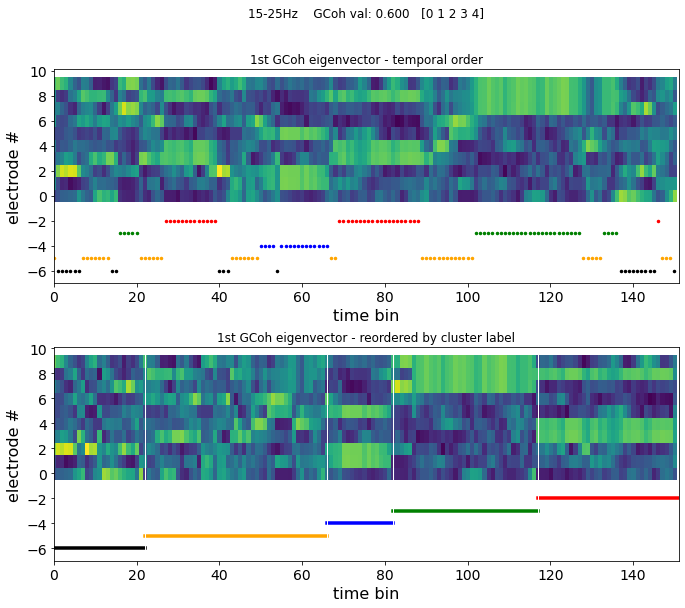

In [48]:
import scipy.stats as _ss
import matplotlib.pyplot as _plt
from sklearn import mixture
from GCoh.eeg_util import unique_in_order_of_appearance, increasing_labels_mapping, rmpd_lab_trnsfrm, find_or_retrieve_GMM_labels, shift_correlated_shuffle, mtfftc
import GCoh.preprocess_ver as _ppv


ch_w_CM, rm_chs, list_ch_names, ch_types = datconf.getConfig(dataset, sim_nchs=10)
arr_ch_names = _N.array(list_ch_names)

ev_n   = 0


_WIDE = 0
_MED  = 1
_FINE = 2
_FINE1 = 3   #



#bin     = 512
#slide   = 64
_WIDE = 0
_FINE = 1

manual_cluster=False

hlfOverlap = int((win/slideby)*0.5)

strt       = 0  #  if start at middle of experiment
A_gcoh     = Cvec[strt:]
fs       = f[findx]



imag_evs  = Cvec[strt:, :, ev_n]

L_gcoh  = A_gcoh.shape[0]
nChs    = imag_evs.shape[2]
real_evs  = _N.empty((L_gcoh, fs.shape[0], nChs))

chs = _N.arange(nChs)
ch_names = arr_ch_names[chs].tolist()

for ti in range(L_gcoh):
    real_evs[ti] = _N.abs(imag_evs[ti])

mn = _N.mean(real_evs, axis=0)
sd = _N.std(real_evs, axis=0)


frngs = [[15, 25]]

ignore_stored = True
pcs     = _N.empty(len(frngs))
minK    =1
maxK    =9
#minK = 6
#maxK = 7
try_Ks  = _N.arange(minK, maxK+1)
#TRs      = _N.array([1, 1, 3, 5, 10, 15, 20, 25, 25])  # more tries for higher K
TRs      = _N.array([1, 15, 20, 25, 25, 30, 40, 50, 60, 60, 60, 60, 60, 60, 80, 80, 80, 80])  # more tries for higher K
#TRs      = _N.array([60])  # more tries for higher K

bics = _N.ones(((maxK-minK), _N.max(TRs)))*1000000
labs = _N.empty((maxK-minK, _N.max(TRs), real_evs.shape[0]), dtype=_N.int)

nState_start = 0

for ich in range(len(frngs)):
    fL = frngs[ich][0]
    fH = frngs[ich][1]

    irngs = _N.where((fs > fL) & (fs < fH))[0]
    iL    = irngs[0]
    iH    = irngs[-1]    

    #Apr242020_16_53_03_gcoh_256_64
    nStates, rmpd_lab = find_or_retrieve_GMM_labels(None, None, None, real_evs, iL, iH, fL, fH, armv_ver, gcoh_ver, which=0, try_K=try_Ks, TRs=TRs, ignore_stored=ignore_stored, manual_cluster=manual_cluster, do_pca=True, min_var_expld=0.95, dontsave=True)
    ps = _N.arange(nStates)
    ps += nState_start
    nState_start += nStates

    #nStates, rmpd_lab = find_or_retrieve_GMM_labels(rpsm[dat], "%(dat)s_gcoh_%(w)d_%(s)d" % {"dat" : dat, "w" : bin, "s" : slide}, real_evs, iL, iH, fL, fH, which=0, try_K=try_Ks, TRs=TRs, log_transform=False)
    """
    ###############
    for K in range(minK, maxK):
        for tr in range(TRs[K]):
            gmm = mixture.GaussianMixture(n_components=K, covariance_type="full")

            gmm.fit(_N.sum(real_evs[:, iL:iH], axis=1))
            bics[K-minK, tr] = gmm.bic(_N.sum(real_evs[:, iL:iH], axis=1))
            labs[K-minK, tr] = gmm.predict(_N.sum(real_evs[:, iL:iH], axis=1))

    coords = _N.where(bics == _N.min(bics))
    print("min bic %.4e" % _N.min(bics))
    bestLab = labs[coords[0][0], coords[1][0]]   #  indices in 2-D array
    rmpd_lab = increasing_labels_mapping(bestLab)

    nStates =  list(range(minK, maxK))[coords[0][0]]
    """
    out_u = _N.mean(real_evs[:, iL:iH], axis=1)
    out = _N.empty((L_gcoh, nChs))
    iS  = 0
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        out[iS:iS+len(ls)] = _N.mean(real_evs[ls, iL:iH], axis=1)
        iS += len(ls)

    iS = 0
    clrs  = ["black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red", "black", "orange", "blue", "green", "red", "lightblue", "grey", "pink", "yellow", "brown", "cyan", "purple", "black", "orange", "blue", "green", "red"]
    W   = L_gcoh
    H   = nChs
    disp_wh_ratio = 5
    aspect = (W/H)/disp_wh_ratio
    unit = 2.5
    fig = _plt.figure(figsize=(disp_wh_ratio*unit + 1, 3*unit+unit/2))
    _plt.subplot2grid((2, 1), (0, 0))        
    _plt.title("1st GCoh eigenvector - temporal order")
    #fig.add_subplot(nStates+2, 1, 1)  
    _plt.imshow(out_u.T, aspect=aspect)
    _plt.ylim(-(nStates+2), nChs+0.1)
    for ns in range(nStates):
        nsx = _N.where(rmpd_lab == ns)[0]
        _plt.scatter(nsx, _N.ones(len(nsx))*ns - nStates - 1, color=clrs[ns], lw=1.5, s=4)
    _plt.xlim(0, L_gcoh)
    _plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
    _plt.ylabel("electrode #", fontsize=16)
    _plt.xlabel("time bin", fontsize=16)
    _plt.xticks(fontsize=14)
    _plt.yticks(fontsize=14)

    _plt.subplot2grid((2, 1), (1, 0))        
    _plt.title("1st GCoh eigenvector - reordered by cluster label")
    #fig.add_subplot(nStates+2, 1, 1)    
    _plt.imshow(out.T, aspect=aspect)
    _plt.ylim(-(nStates+2), nChs+0.1)
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        liS = iS
        iS += len(ls)
        _plt.plot([liS, iS], [ns-nStates-1, ns-nStates-1], color=clrs[ns], lw=3.5)
        if ns < nStates-1:
            _plt.axvline(x=iS, color="white", lw=1)
    _plt.xlim(0, L_gcoh)
    _plt.suptitle("%(1)d-%(2)dHz    GCoh val: %(gcoh).3f   %(sts)s" % {"1" : fL, "2" : fH, "gcoh" : _N.mean(Ctot[:, irngs]), "sts" : str(ps)})
    _plt.xlabel("(sample #) - not in experimental temporal order", fontsize=17)
    _plt.ylabel("electrode #", fontsize=16)
    _plt.xlabel("time bin", fontsize=16)
    _plt.xticks(fontsize=14)
    _plt.yticks(fontsize=14)

    iS = 0
    for ns in range(nStates):
        ls = _N.where(rmpd_lab == ns)[0]
        iS += len(ls)
        if ns < nStates-1:
            _plt.axvline(x=iS, color="white", lw=1)
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, hspace=0.3)

  

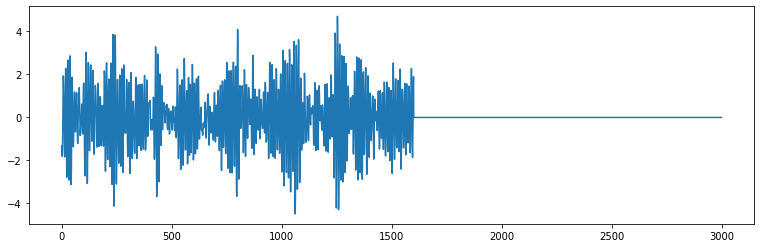

In [30]:
fig = _plt.figure(figsize=(13, 4))
_plt.plot(EEG[3, 2000:5000] - EEG[4, 2000:5000])


In [25]:
slideby

64

In [42]:
L_gcoh

151

In [43]:
win

512

In [44]:
slideby

64

In [46]:
(64/200)*L_gcoh

48.32

In [47]:
N*dt

100.0